In [1]:
#!/usr/bin/env python
# coding: utf-8
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from numpy import cos, sin, pi
from numpy.random import randint as r_int

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten,Dense

from PIL import Image as IM, ImageDraw as ID

from IPython.display import display, Image


In [2]:
def init_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape = (200, 200,1), activation='relu'))
    model.add(MaxPooling2D(pool_size = (8, 8)))
    model.add(Flatten())
    model.add(Dense(units = 64, activation = 'sigmoid'))
    model.add(Dense(units = 7, activation = 'sigmoid'))
    model.summary()
    return model

In [3]:
# Generates the Transformation Matrix for a Point
#   coord: The (x,y,z) point to transform
#   angle: The (a,b,c) angle to transform by
def shear_trans(coord=(0,0,0),angle=(0,0,0)):
    rot_x = np.array([[1,0,0],
                      [0,cos(angle[0]), sin(angle[0])],
                      [0,-sin(angle[0]),cos(angle[0])]],
                    dtype='float32')
    rot_y = np.array([[cos(angle[1]), 0, sin(angle[1])],
                      [0, 1, 0],
                      [-sin(angle[1]), 0, cos(angle[1])]],
                    dtype='float32')
    rot_z = np.array([[cos(angle[2]), -sin(angle[2]), 0],
                      [sin(angle[2]), cos(angle[2]), 0],
                      [0, 0, 1]],
                    dtype='float32')

    return np.dot(rot_x, rot_y, rot_z)

# Generates Points for Polygons of Specified Features
#   sides: Number of sides of polygon [default:3]
#   coord: Center of the polygon  
#   angle: Angle to rotate about center
#   scale: Value to magnify the polygon
#   shear: 3d Rotation to apply to polygon
def poly_gen(sides = 3,coord = (0,0), angle = 0, scale = 1, shear = (0,0,0)):
    p,x,y = [], *coord
    
    #Loop Through and Create All Verticies
    for s in range(sides):
        p.append( ( cos(s * 2 * pi / sides + angle) + x, sin(s * 2 * pi / sides + angle) + y))
        
    # Perform Shear Transform
    p = map(lambda q: np.dot(shear_trans((0,0,0), shear), np.array([*q,0]).T), p)
    p = list(map(lambda q: tuple(scale * (1 +  q.T[:-1] + np.array([x,y]))), p))
    
    return p

# Generates Data Set of Polygons
#   size: Number of Polygons to generate/Data Set Size
#   side_range: Range of sides
#   dim: Dimensions of the image
#   color: Color of the polygon
#   filled: Wether or not to fill in the polygon
#   output_dir: Whether or not to save images & where to save them
#   seed: Seed for numpy.random
def gen_poly_data(size = 1,side_range=(3,10), dim = (100,100), color=0, filled=True, output_dir = None, seed = 0):
    
    np.random.seed(seed)
    data = {'x':[],'y':[]}
    
    # Generate Random Shapes
    for i in range(size):
        img = IM.new('L', dim,"#ffffff")
        draw = ID.Draw(img) 
        center = (1,1)#np.random.rand(2) * 3
        scale = np.random.randint(np.min(dim)/8, np.min(dim)/4)
        fill_color = color if filled else None
        num_sides = r_int(*side_range)

        draw.polygon(poly_gen(sides = num_sides,
                             coord = center,
                             angle = 0 * 2 * pi * np.random.rand(),
                             scale = scale,
                             shear = pi / 2 * np.random.rand(3) - pi/4),
                     fill = fill_color, outline = color)
        
        # Save Image to output folder if given
        if output_dir:
            img.save(os.path.join(output_dir,'img_{}_class_{}.jpg'.format(num_sides,i)))
        
        data['x'].append(np.array(img,dtype='float32').reshape(200,200,1)/255)
        
        # One Hot Encode Label
        one_hot = np.zeros(side_range[1] - side_range[0])
        one_hot[num_sides - side_range[0]] = 1
        data['y'].append(one_hot.T)
        
    return data

In [4]:
train_size, test_size = 10000, 500
train_set = gen_poly_data(train_size,side_range=(3,10), dim = (200,200), color=0, filled=True, output_dir = None, seed = 0)
test_set = gen_poly_data(test_size,side_range=(3,10), dim = (200,200), color=0, filled=True, output_dir = None, seed = 0)


model = init_model()

W0726 16:33:17.971298 29988 deprecation.py:506] From c:\users\jaures\documents\workspace\sujunn\env\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1179712   
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 455       
Total params: 1,180,487
Trainable params: 1,180,487
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.compile(optimizer = tf.train.AdamOptimizer(), loss = 'mean_squared_error', metrics=['accuracy'])
model.fit(np.array(train_set['x']), np.array(train_set['y']), batch_size = 32, epochs = 8, validation_split=0.1)



Train on 9000 samples, validate on 1000 samples
Epoch 1/8
9000/9000 [==============================] - 72s 8ms/sample - loss: 0.1216 - acc: 0.2043 - val_loss: 0.1160 - val_acc: 0.2470
Epoch 2/8
9000/9000 [==============================] - 74s 8ms/sample - loss: 0.1124 - acc: 0.2756 - val_loss: 0.1088 - val_acc: 0.2640
Epoch 3/8
9000/9000 [==============================] - 73s 8ms/sample - loss: 0.1059 - acc: 0.3549 - val_loss: 0.1031 - val_acc: 0.4110
Epoch 4/8
9000/9000 [==============================] - 73s 8ms/sample - loss: 0.1013 - acc: 0.4259 - val_loss: 0.0990 - val_acc: 0.5430
Epoch 5/8
9000/9000 [==============================] - 75s 8ms/sample - loss: 0.0967 - acc: 0.5321 - val_loss: 0.0928 - val_acc: 0.5660
Epoch 6/8
9000/9000 [==============================] - 84s 9ms/sample - loss: 0.0853 - acc: 0.6013 - val_loss: 0.0739 - val_acc: 0.6930
Epoch 7/8
9000/9000 [==============================] - 103s 11ms/sample - loss: 0.0600 - acc: 0.7660 - val_loss: 0.0432 - val_acc: 0.894

In [6]:
model.compile(optimizer = tf.train.AdamOptimizer(), loss = 'categorical_crossentropy', metrics=['accuracy', 'categorical_accuracy'])
model.fit(np.array(train_set['x']), np.array(train_set['y']), batch_size = 32, epochs = 16, validation_split=0.1)



W0726 16:43:58.647400 29988 deprecation.py:323] From c:\users\jaures\documents\workspace\sujunn\env\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 9000 samples, validate on 1000 samples
Epoch 1/16
9000/9000 [==============================] - 84s 9ms/sample - loss: 0.1398 - acc: 0.9831 - categorical_accuracy: 0.9831 - val_loss: 0.0986 - val_acc: 0.9840 - val_categorical_accuracy: 0.9840
Epoch 2/16
9000/9000 [==============================] - 91s 10ms/sample - loss: 0.0519 - acc: 0.9947 - categorical_accuracy: 0.9947 - val_loss: 0.0525 - val_acc: 0.9900 - val_categorical_accuracy: 0.9900
Epoch 3/16
9000/9000 [==============================] - 99s 11ms/sample - loss: 0.0253 - acc: 0.9984 - categorical_accuracy: 0.9984 - val_loss: 0.0337 - val_acc: 0.9940 - val_categorical_accuracy: 0.9940
Epoch 4/16
9000/9000 [==============================] - 110s 12ms/sample - loss: 0.0151 - acc: 0.9993 - categorical_accuracy: 0.9993 - val_loss: 0.0248 - val_acc: 0.9960 - val_categorical_accuracy: 0.9960
Epoch 5/16
9000/9000 [==============================] - 117s 13ms/sample - loss: 0.0091 - acc: 1.0000 - categorical_accuracy: 1.0000 - v

In [12]:
Out[6].history

{'loss': [0.13981457281774945,
  0.051917273339298034,
  0.025317113563004468,
  0.01506109925525056,
  0.009130497299962573,
  0.005954705139415132,
  0.00412865105498996,
  0.0029344878236038817,
  0.0022184782849831715,
  0.0017520560723625952,
  0.0013271999655084478,
  0.0010602991305705574,
  0.0008653202860409186,
  0.0007083182915424307,
  0.0005805849951898886,
  0.00048567273328080775],
 'acc': [0.9831111,
  0.9946667,
  0.99844444,
  0.9993333,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'categorical_accuracy': [0.9831111,
  0.9946667,
  0.99844444,
  0.9993333,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.09864389216899871,
  0.05250063815712929,
  0.03373104140162468,
  0.024808493584394454,
  0.018203245982527733,
  0.016666803665459157,
  0.012242754267528654,
  0.010363148182630538,
  0.009573513600975275,
  0.009802710603922606,
  0.00912589061446488,
  0.00826566299702972

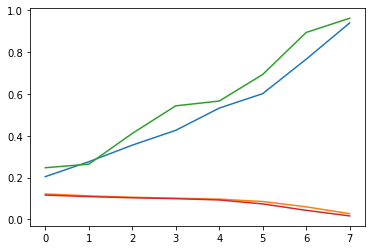

In [11]:
plt.plot(Out[5].history['acc'])
plt.plot(Out[5].history['loss'])
plt.plot(Out[5].history['val_acc'])
plt.plot(Out[5].history['val_loss'])
plt.show()

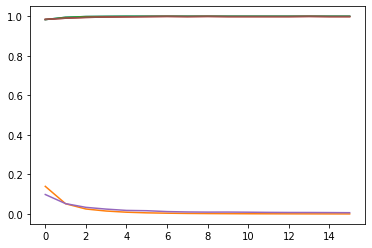

In [16]:
plt.plot(Out[6].history['acc'])
plt.plot(Out[6].history['loss'])
plt.plot(Out[6].history['categorical_accuracy'])
plt.plot(Out[6].history['val_acc'])
plt.plot(Out[6].history['val_loss'])
plt.plot(Out[6].history['val_categorical_accuracy'])
plt.show()

In [25]:
for i in range(test_size):
    print(model.predict(np.array(test_set['x'][i]).reshape(1,200,200,1)),test_set['y'][i], sep='\n',end='\n======\n\n')

[[1.0521972e-07 1.9251846e-05 3.9571319e-06 1.8719016e-05 2.9348519e-06
  2.1792042e-01 8.1104103e-05]]
[0. 0. 0. 0. 0. 1. 0.]

[[3.1707777e-06 1.0174052e-06 2.7147425e-05 7.8973238e-07 3.2054126e-01
  5.7503894e-05 1.4618122e-05]]
[0. 0. 0. 0. 1. 0. 0.]

[[5.8300634e-06 2.2087349e-06 1.9778442e-06 2.5492354e-05 4.3331474e-05
  1.0679894e-05 1.9769764e-02]]
[0. 0. 0. 0. 0. 0. 1.]

[[5.4345679e-01 1.1278500e-05 1.3026071e-05 6.7272972e-06 2.2508730e-05
  4.9501335e-07 4.5989736e-06]]
[1. 0. 0. 0. 0. 0. 0.]

[[7.2164812e-07 1.6628678e-01 1.6348336e-06 4.4860508e-06 0.0000000e+00
  9.9683393e-06 4.6451946e-06]]
[0. 1. 0. 0. 0. 0. 0.]

[[1.4086511e-06 2.4503100e-01 1.0855763e-06 4.3582073e-05 2.9299559e-07
  2.1498638e-05 1.7222811e-06]]
[0. 1. 0. 0. 0. 0. 0.]

[[1.5065294e-05 1.1852675e-05 5.7847047e-01 1.2557629e-07 2.3765091e-04
  1.3641723e-05 6.3309694e-06]]
[0. 0. 1. 0. 0. 0. 0.]

[[4.5794380e-01 1.5291536e-05 4.1461558e-06 4.0960117e-06 6.6426655e-05
  1.1042207e-06 2.5226100e-06]]


[[2.2449993e-05 1.2693493e-05 4.8280442e-01 3.4896769e-07 7.4940576e-04
  8.3115829e-06 5.4487696e-06]]
[0. 0. 1. 0. 0. 0. 0.]

[[4.8844067e-06 7.1119543e-06 4.8797790e-07 2.9438302e-01 1.6630254e-06
  1.8963701e-05 5.6719426e-05]]
[0. 0. 0. 1. 0. 0. 0.]

[[4.66707252e-06 1.19028166e-01 9.57749648e-08 3.11777003e-05
  5.56852228e-06 9.85409497e-06 7.90549223e-07]]
[0. 1. 0. 0. 0. 0. 0.]

[[3.7323603e-01 1.0312737e-05 4.1070184e-06 5.8753067e-06 1.8239680e-05
  1.7357910e-07 8.3748700e-06]]
[1. 0. 0. 0. 0. 0. 0.]

[[1.3680316e-06 2.4925384e-05 1.4753893e-07 4.5194796e-01 1.2845404e-06
  5.2485389e-05 6.1467767e-06]]
[0. 0. 0. 1. 0. 0. 0.]

[[1.5742506e-06 2.4439228e-06 2.9417954e-05 1.0354182e-07 3.9156851e-01
  3.8753165e-05 3.6625846e-05]]
[0. 0. 0. 0. 1. 0. 0.]

[[2.4069485e-07 1.2137846e-05 6.4583890e-07 3.6221450e-06 2.9385397e-05
  5.0267982e-01 2.3427687e-05]]
[0. 0. 0. 0. 0. 1. 0.]

[[8.21795183e-08 1.08719805e-05 1.77068125e-06 1.25466640e-05
  1.63661355e-06 4.46925819e-01 1.0

[[8.6404231e-07 4.0308328e-06 1.6052983e-06 1.8320775e-06 3.1444466e-05
  1.7476790e-05 2.3721185e-01]]
[0. 0. 0. 0. 0. 0. 1.]

[[1.0939179e-07 1.8239820e-05 3.8649082e-06 5.5560245e-06 5.6980907e-06
  7.1383238e-02 6.5237728e-05]]
[0. 0. 0. 0. 0. 1. 0.]

[[3.5008175e-06 1.3942621e-06 1.6102162e-05 2.0333584e-06 5.9943867e-01
  4.7012334e-05 2.8780058e-05]]
[0. 0. 0. 0. 1. 0. 0.]

[[4.8166444e-06 1.0678785e-05 5.8517021e-01 1.5740088e-06 4.3901389e-05
  6.7866713e-06 6.0838734e-06]]
[0. 0. 1. 0. 0. 0. 0.]

[[6.9345842e-06 1.9912966e-05 8.2069767e-01 2.2506097e-07 4.4830584e-05
  1.1358125e-05 1.5005804e-05]]
[0. 0. 1. 0. 0. 0. 0.]

[[7.5758830e-06 6.7144390e-07 1.1617619e-05 2.0269151e-06 3.0749151e-01
  7.7977063e-07 3.1336160e-05]]
[0. 0. 0. 0. 1. 0. 0.]

[[2.1732749e-05 8.1296940e-07 4.1609228e-06 3.0846486e-06 4.2683139e-01
  3.4725376e-06 8.2523911e-05]]
[0. 0. 0. 0. 1. 0. 0.]

[[2.5629079e-05 5.2699756e-06 4.7903565e-01 4.4645490e-06 9.0061556e-05
  2.2146428e-06 4.9417936e-06]]


[[1.5166182e-07 1.3719729e-05 7.0865585e-06 4.4319186e-06 6.9702270e-05
  3.2494217e-01 1.4976952e-05]]
[0. 0. 0. 0. 0. 1. 0.]

[[6.2523982e-06 8.3407670e-02 7.0944452e-08 1.4260526e-04 1.7666756e-07
  3.3356813e-05 8.6250526e-07]]
[0. 1. 0. 0. 0. 0. 0.]

[[6.0731566e-08 1.4438299e-05 3.5409089e-06 1.4143399e-05 4.0246755e-06
  3.3295920e-01 3.3960081e-05]]
[0. 0. 0. 0. 0. 1. 0.]

[[1.0564001e-05 1.7053868e-05 5.9703982e-01 4.3560638e-07 5.3962740e-05
  8.2873394e-06 2.6775842e-05]]
[0. 0. 1. 0. 0. 0. 0.]

[[1.1566793e-06 1.5542622e-05 2.0684568e-07 4.2547107e-01 2.3331622e-06
  1.4455301e-05 5.9971026e-06]]
[0. 0. 0. 1. 0. 0. 0.]

[[1.0472014e-06 6.4154701e-06 6.6836719e-06 3.9420574e-06 1.3158443e-05
  9.8325700e-06 4.1718411e-01]]
[0. 0. 0. 0. 0. 0. 1.]

[[6.39486302e-07 1.23790346e-01 1.07400183e-06 1.19181213e-05
  1.41622905e-07 5.20679578e-06 3.00410107e-07]]
[0. 1. 0. 0. 0. 0. 0.]

[[2.8205913e-01 1.6246026e-05 8.4966359e-06 4.8993165e-06 6.9318805e-05
  6.4272558e-07 1.3795162

[[5.3466158e-07 1.2574286e-05 5.8842561e-06 1.3482382e-05 3.7597954e-05
  2.3022199e-01 2.0990023e-05]]
[0. 0. 0. 0. 0. 1. 0.]

[[1.5326983e-06 2.5680089e-01 2.9081664e-06 8.4856792e-06 2.7651037e-08
  7.9255051e-06 3.5273699e-06]]
[0. 1. 0. 0. 0. 0. 0.]

[[4.8127103e-01 2.7153950e-05 1.9585538e-04 4.6232740e-06 1.6879478e-05
  3.3744991e-06 5.2045962e-06]]
[1. 0. 0. 0. 0. 0. 0.]

[[7.7849256e-07 1.3850723e-01 4.7769373e-07 1.4256638e-05 3.7304511e-07
  5.7057800e-06 6.9399562e-07]]
[0. 1. 0. 0. 0. 0. 0.]

[[1.06056705e-05 1.18559201e-05 5.63645303e-01 6.26172096e-07
  9.49842706e-06 2.50136327e-05 3.58447869e-05]]
[0. 0. 1. 0. 0. 0. 0.]

[[1.4588085e-06 1.3753173e-05 4.2003791e-07 1.8646844e-01 3.2481628e-06
  2.2704353e-05 2.1531261e-05]]
[0. 0. 0. 1. 0. 0. 0.]

[[9.1047978e-06 5.7970474e-06 5.9126663e-01 4.6069099e-06 4.1907344e-05
  4.5181882e-06 3.4775483e-06]]
[0. 0. 1. 0. 0. 0. 0.]

[[6.3133525e-06 2.1793330e-06 1.3362393e-05 1.0075180e-06 7.6140881e-01
  4.9627473e-05 2.7423792

[[6.9972759e-07 3.1673979e-05 1.3069990e-07 1.7719410e-01 1.2878793e-06
  2.1267293e-05 1.2302245e-05]]
[0. 0. 0. 1. 0. 0. 0.]

[[3.1418463e-07 1.3786108e-05 9.4282495e-06 4.3508180e-06 3.6847371e-06
  1.0959162e-05 3.2279366e-01]]
[0. 0. 0. 0. 0. 0. 1.]

[[6.30841123e-06 1.32204775e-06 5.23119488e-05 5.76606055e-07
  6.37983456e-02 7.57722737e-05 1.06040425e-05]]
[0. 0. 0. 0. 1. 0. 0.]

[[6.4221811e-01 1.4660325e-05 3.5149585e-06 3.8376977e-05 1.5821095e-05
  1.1752917e-07 1.6569304e-05]]
[1. 0. 0. 0. 0. 0. 0.]

[[7.9902247e-06 7.1981067e-06 5.3948325e-01 2.3701459e-06 2.1145750e-05
  4.8418042e-06 7.8892699e-06]]
[0. 0. 1. 0. 0. 0. 0.]

[[3.1814307e-06 6.2566238e-07 1.0826982e-05 5.9520119e-07 2.5277507e-01
  1.0908965e-05 6.1631203e-05]]
[0. 0. 0. 0. 1. 0. 0.]

[[3.3910453e-06 6.1948225e-07 7.7721534e-06 5.1516560e-07 4.2035088e-01
  2.3405935e-05 3.6651214e-05]]
[0. 0. 0. 0. 1. 0. 0.]

[[2.36977326e-06 8.72867815e-07 1.42429535e-05 2.14553225e-07
  3.20417196e-01 3.77493525e-05 2.8

[[1.6647343e-07 3.5141657e-05 1.4381778e-06 2.0408015e-05 2.3768800e-06
  1.5614696e-01 9.2309137e-04]]
[0. 0. 0. 0. 0. 1. 0.]

[[2.0441439e-05 1.7016578e-06 7.7297875e-05 1.3380613e-07 6.7138486e-02
  1.4982224e-05 7.7661143e-06]]
[0. 0. 0. 0. 1. 0. 0.]

[[2.58602967e-07 1.16061465e-05 8.50847755e-07 9.44778094e-06
  4.67597420e-06 4.40618336e-01 2.24236956e-05]]
[0. 0. 0. 0. 0. 1. 0.]

[[6.2890272e-06 1.3440175e-06 4.5913921e-06 1.8310992e-06 4.4820288e-01
  4.1894277e-06 1.1428682e-04]]
[0. 0. 0. 0. 1. 0. 0.]

[[5.2092296e-06 7.9430292e-06 4.1551790e-01 1.1772452e-06 1.7545090e-05
  6.7594906e-06 1.1170355e-05]]
[0. 0. 1. 0. 0. 0. 0.]

[[8.2504209e-07 2.9557739e-05 1.1346133e-06 1.8417978e-01 2.2884555e-07
  1.1503710e-04 4.0039133e-05]]
[0. 0. 0. 1. 0. 0. 0.]

[[5.1778036e-01 1.0054314e-05 2.0580687e-06 3.9886622e-06 1.9807716e-05
  1.1078724e-06 7.1729169e-06]]
[1. 0. 0. 0. 0. 0. 0.]

[[1.4926106e-05 4.1433509e-07 4.3400662e-05 2.2801889e-05 2.0968817e-02
  1.6780023e-06 1.6588482